In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils

import numpy as np
import random
# Assume words is a list of names
words = open("input.txt", "r").read().splitlines()

# Creating the character dictionary
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos) #27

# Hyperparameters
context_length = 3
input_size = vocab_size
hidden_size = 128
output_size = vocab_size

# One-hot encoding function
def one_hot_encode(index, size):
    vec = np.zeros(size, dtype=np.float32)
    vec[index] = 1.0
    return vec

# Function to map one-hot encoded vectors to index
def one_hot_to_index(one_hot_vec):
    return np.argmax(one_hot_vec)

# Function to map index to character
def index_to_char(index):
    return itos[index]

torch.manual_seed(1219)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    def __init__(self, words, stoi, context_length, vocab_size):
        self.words = words
        self.stoi = stoi
        self.context_length = context_length
        self.vocab_size = vocab_size
        self.X, self.Y = self.build_dataset()

    def one_hot_encode(self, index):
        vec = np.zeros(self.vocab_size, dtype=np.float32)
        vec[index] = 1.0
        return vec

    def build_dataset(self):
        X, Y = [], []
        for w in self.words:
            context = [0] * self.context_length
            for ch in w + '.':
                ix = self.stoi[ch]
                one_hot_context = [self.one_hot_encode(c) for c in context]
                X.append(np.array(one_hot_context))
                Y.append(ix)
                context = context[1:] + [ix]
        X = torch.tensor(X, dtype=torch.float)
        Y = torch.tensor(Y)
        return X, Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [ ]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

train_words = words[:n1]
dev_words = words[n1:n2]

test_words = words[n2:]

train_dataset = CharDataset(train_words, stoi, context_length, vocab_size)
dev_dataset = CharDataset(dev_words, stoi, context_length, vocab_size)
test_dataset = CharDataset(test_words, stoi, context_length, vocab_size)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### LSTM

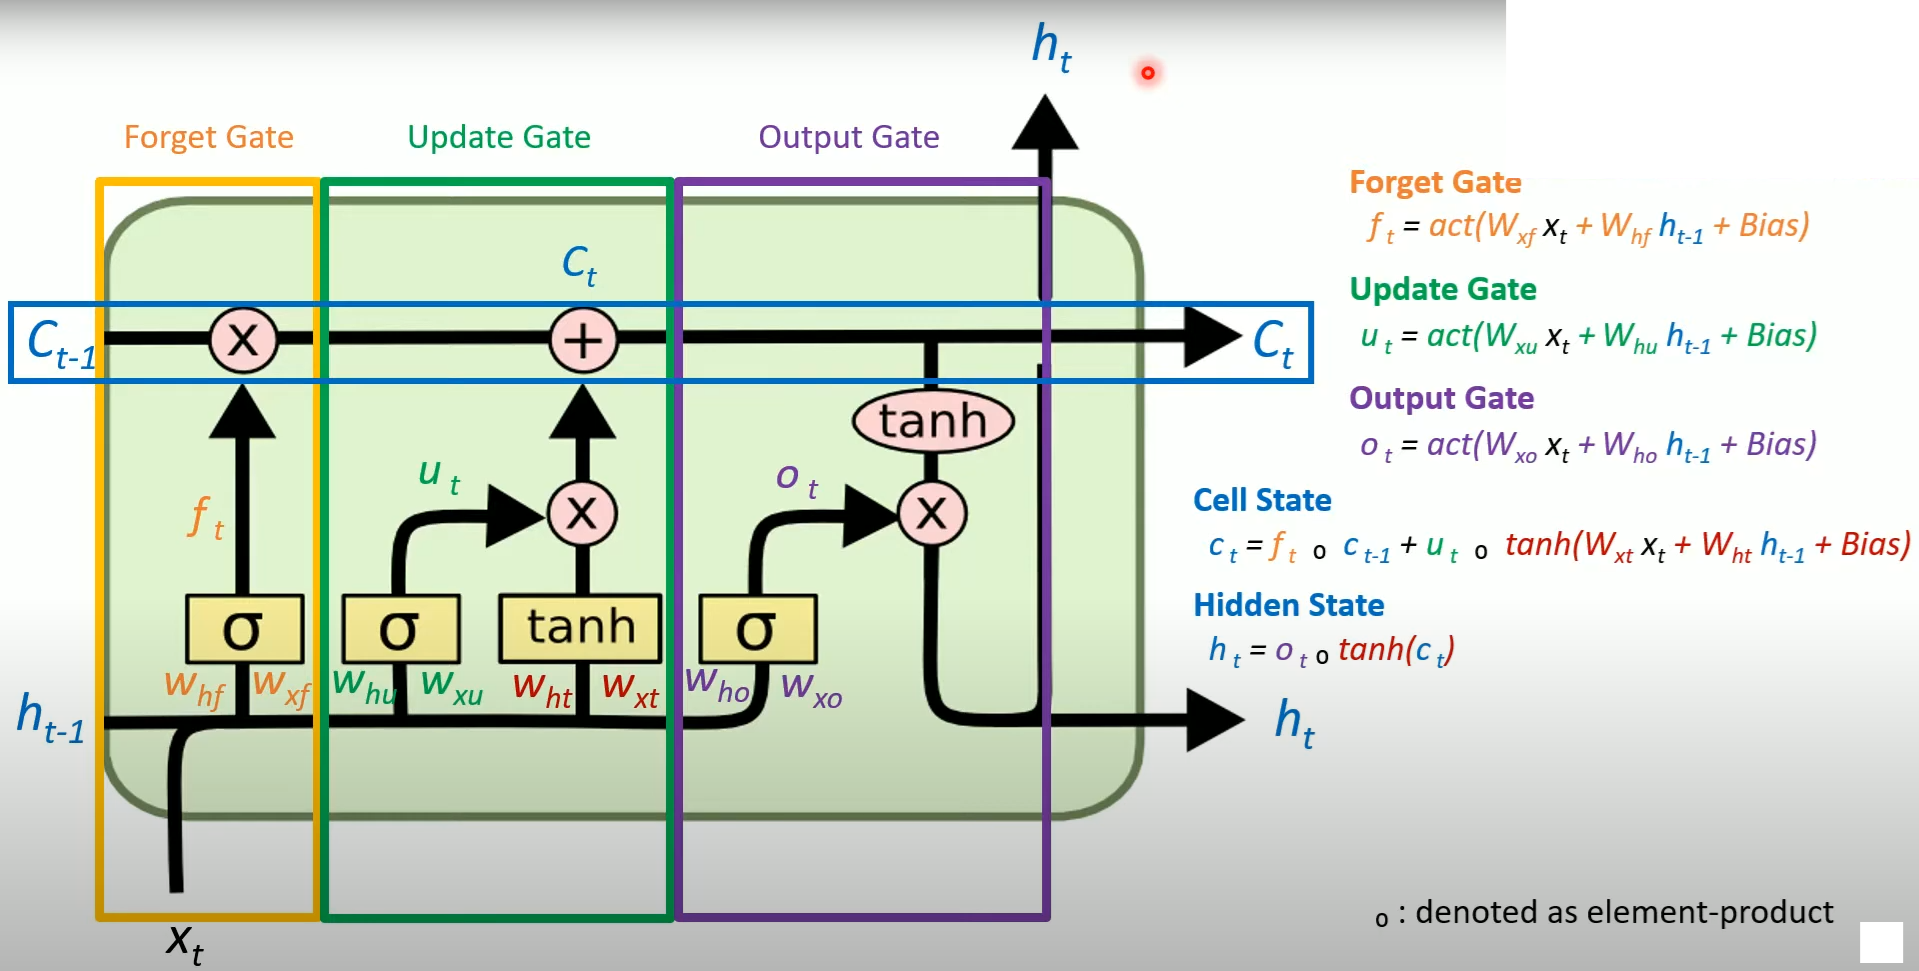

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.forget_gate = nn.Linear(
            self.input_size + self.hidden_size, self.hidden_size
        )
        self.update_gate = nn.Linear(
            self.input_size + self.hidden_size, self.hidden_size
        )
        self.output_gate = nn.Linear(
            self.input_size + self.hidden_size, self.hidden_size
        )
        self.cell_layer = nn.Linear(
            self.input_size + self.hidden_size, self.hidden_size
        )

        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, hprev, cprev):
        combined = torch.cat((x, hprev), 1)

        ft = self.sigmoid(self.forget_gate(combined))
        ut = self.sigmoid(self.update_gate(combined))
        ot = self.sigmoid(self.output_gate(combined))

        cell_candidate = self.tanh(self.cell_layer(combined))

        ct = ft * cprev + ut * cell_candidate
        ht = ot * self.tanh(ct)

        return ht, ct

In [ ]:
lstm_model = LSTM(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

steps = []
losses = []

num_epochs = 20

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:

        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        hprev = torch.zeros(X_batch.size(0), hidden_size).to(device)
        cprev = torch.zeros(X_batch.size(0), hidden_size).to(device)

        # forward pass
        outputs = []
        for t in range(X_batch.size(1)):
            xt = X_batch[:, t, :]
            hprev, cprev = lstm_model(xt, hprev, cprev)
            outputs.append(hprev)

        outputs = torch.stack(outputs, dim=1)
        outputs = outputs[:, -1, :]
        outputs = lstm_model.fc(outputs)

        # compute loss
        loss = criterion(outputs, Y_batch)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    steps.append(epoch)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [ ]:
# Evaluation on the validation set
lstm_model.eval()
with torch.no_grad():
    total_loss = 0
    for X_batch, Y_batch in dev_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # Initialize the hidden state
        # X_batch shape is 32 x 3 x 27 (B,T,C)
        hprev = torch.zeros(X_batch.size(0), hidden_size).to(device)
        cprev = torch.zeros(X_batch.size(0), hidden_size).to(device)

        outputs = []
        for t in range(X_batch.size(1)):
            xt = X_batch[:, t, :]
            hprev, cprev = lstm_model(xt, hprev, cprev)
            outputs.append(hprev)

        outputs = torch.stack(outputs, dim=1)
        outputs = outputs[:, -1, :]  # Take the last hidden state for each sequence
        outputs = lstm_model.fc(outputs)

        loss = criterion(outputs, Y_batch)
        total_loss += loss.item()

    avg_loss = total_loss / len(dev_loader)
    print(f'Validation Loss: {avg_loss:.4f}')

In [ ]:
import torch.nn.functional as F

def generate_text(model, stoi, itos, initial_text, max_length=100, temperature=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    context = [stoi[ch] for ch in initial_text]
    context = torch.tensor([one_hot_encode(ix, vocab_size) for ix in context], dtype=torch.float).unsqueeze(0).to(device)
    hprev = torch.zeros(1, hidden_size).to(device)
    cprev = torch.zeros(1, hidden_size).to(device)

    generated_text = initial_text

    with torch.no_grad():
        for _ in range(max_length):
            xt = context[:, -1, :]  # Get the last character in the current context
            hprev, cprev = model(xt, hprev, cprev)
            output = model.fc(hprev)

            # Apply temperature
            # output = output / temperature

            # Convert to probabilities
            probs = F.softmax(output, dim=1).squeeze()

            # Sample from the distribution
            char_idx = torch.multinomial(probs, 1).item()
            generated_char = itos[char_idx]

            # Append the generated character to the context and the generated text
            generated_text += generated_char
            new_context = torch.tensor(one_hot_encode(char_idx, vocab_size), dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            context = torch.cat([context, new_context], dim=1)

            if generated_char == '.':
                break

    return generated_text

# Example usage:
initial_text = "a"  # Initial seed text
generated_text = generate_text(lstm_model, stoi, itos, initial_text)
print("Generated Text:", generated_text)
